<a href="https://colab.research.google.com/github/pthkbs123/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_03_Generative_Model_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.03 Generative Model - DCGAN

* 날짜: 2022-08-09, 10
* 이름: 박태현

## 학습내용
    - 딥러닝 생성모델에 대해 이해한다.
    - Deep Convolutional Generative Adversarial Networks 를 구현한다.

> https://arxiv.org/pdf/1406.2661.pdf



## 실습
---

### | **모델 구현**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-02.PNG?raw=true' width=800>
</p>

In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils

def build_generator(z_dim = 64, img_shape = (28,28,1)):
  w, h, c = img_shape

  z = layers.Input(shape=[z_dim]) # 길이가 (z_dim)벡터
  y = layers.Dense( int(w/4) * int(h/4) * 128)(z)
  y = layers.Reshape( [int(w/4),int(h/4), 128])(y)

  y = layers.BatchNormalization()(y)
  y = layers.Conv2DTranspose(64, kernel_size=5, padding = 'same', strides=2, activation = 'relu')(y)
  y = layers.BatchNormalization()(y)
  y = layers.Conv2DTranspose(c, kernel_size=5, padding = 'same', strides=2, activation='sigmoid')(y)
  # 크기가 img_shape. (h,w,c) 텐서

  return models.Model(z, y, name = 'Generator')

def build_disc(img_shape = (28,28,1)):
  x = layers.Input(shape = img_shape)
  y = layers.Conv2D(64, kernel_size=5, strides = 2, padding = 'same', activation = 'relu')(x)
  y = layers.Dropout(.5)(y)

  y = layers.Conv2D(128, kernel_size=5, strides = 2, padding = 'same', activation = 'relu')(y)
  y = layers.Dropout(.5)(y)

  y = layers.Flatten()(y)

  y = layers.Dense(1, activation = 'sigmoid')(y)

  return models.Model(x, y, name = 'Discriminator')



def build_gan(z_dim, img_shape):
  gene = build_generator(z_dim, img_shape)
  disc = build_disc(img_shape)
  
  z = layers.Input(shape=[z_dim])
  fake_img = gene(z)
  logit = disc(fake_img)

  return models.Model(z, logit, name = 'GAN')

g = build_generator(128,(32,32,3))
g.summary()

d = build_disc((32,32,3))
d.summary()

gan = build_gan(128, (32,32,3))
gan.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_21 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_10 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_20 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 16, 16, 64)       204864    
 Transpose)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 16, 16, 64)       25

(1, 32, 32, 3)
[[0.4979906]]


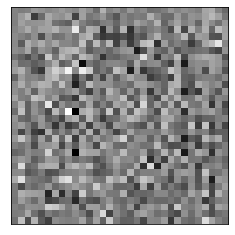

In [12]:
import matplotlib.pyplot as plt

z = tf.random.normal([1,128])
fake_img = g.predict(z)
print(fake_img.shape)
plt.imshow(fake_img[0,:,:,0], cmap = 'gray');plt.xticks([]);plt.yticks([])
logit = d.predict(fake_img)
print(logit)

### 데이터

In [28]:
batch_size = 32

# def get_mnist():
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.
x_train = np.expand_dims(x_train, 3)

ds = tf.data.Dataset.from_tensor_slices(x_train)
ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)

for x in ds.take(1):
  print(x.shape)
  break


(32, 28, 28, 1)


(60000, 28, 28, 1)

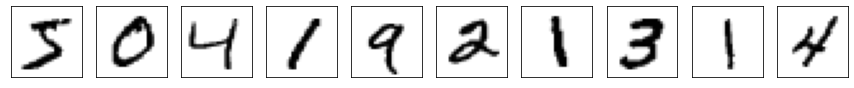

In [30]:
def display_sample_img(samples, cmap='gray_r'):
  plt.figure(figsize=(15,3))
  for i,sample in enumerate(samples):
    #sample = ( sample  + 1. ) / 2.
    #sample = np.clip(sample, 0, 1)
    if i==10:break
    plt.subplot(1,10,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap=cmap)
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()

display_sample_img(x_train[:10])

### **| 학습**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-01.PNG?raw=true' width=600>
</p>

In [13]:
import numpy as np

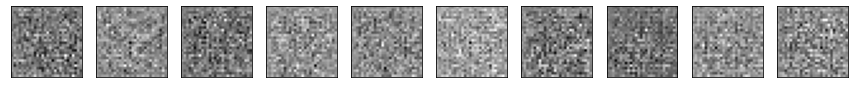

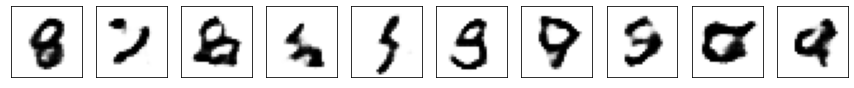

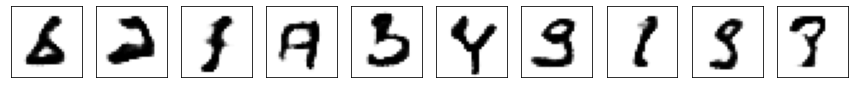

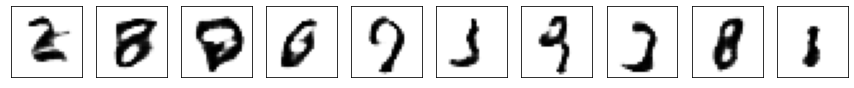

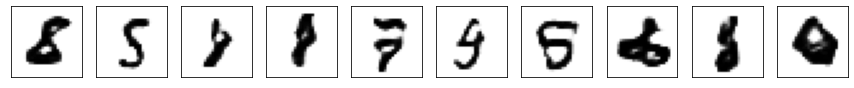

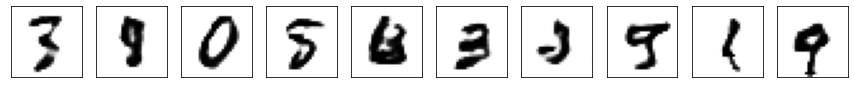

In [33]:
noise_dims = 100
epochs = 5
batch_size = 32
img_shape = (28,28,1)

ones = tf.constant([1.], shape = [batch_size, 1])
zeros = tf.constant([0.], shape = [batch_size, 1])

# 모델 만들기
G = build_generator(noise_dims, img_shape)
D = build_disc(img_shape)

# 컴파일
loss = 'binary_crossentropy'
optimizer = 'adam'
D.compile(loss = loss, optimizer = optimizer)

D.trainable = False
input_noises = layers.Input(shape = noise_dims)
fake_img = G(input_noises)
logit = D(fake_img)
GAN = models.Model(input_noises, logit)
GAN.compile(loss = loss, optimizer = optimizer)
GAN.summary

for epoch in range(epochs+1):
  if epoch != 0:
    for real_imgs in ds: # 20000개중 32개씩
      noises = tf.random.normal(shape = [batch_size, noise_dims]) # p (가우시안 확률분포)
      fake_imgs = G.predict_on_batch(noises)

      # phase 1 : 판별자 훈련
      D.trainable = True 
      # 진짜 이미지 (real_imgs)가 들어오면 1로 대답
      D_loss_real = D.train_on_batch(real_imgs, ones)
      
      # 가짜 이미지 (fake_imgs = G(noises))가 들어오면 0으로 대답
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)

      D_loss = (0.5 * D_loss_real * 0.5 + D_loss_fake) / float(batch_size)

      # phase 2 : 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape = [batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones)

  noises = tf.random.normal(shape = [batch_size, noise_dims])
  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])

In [37]:
# f-mnist 까지 적용해보기

batch_size = 32

# def get_mnist():
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.
x_train = np.expand_dims(x_train, 3)

ds = tf.data.Dataset.from_tensor_slices(x_train)
ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)


4431872/4422102 [==============================] - 0s 0us/step


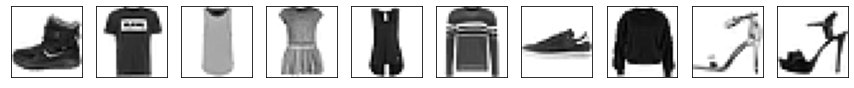

In [39]:
def display_sample_img(samples, cmap='gray_r'):
  plt.figure(figsize=(15,3))
  for i,sample in enumerate(samples):
    #sample = ( sample  + 1. ) / 2.
    #sample = np.clip(sample, 0, 1)
    if i==10:break
    plt.subplot(1,10,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap=cmap)
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()

display_sample_img(x_train[:10])

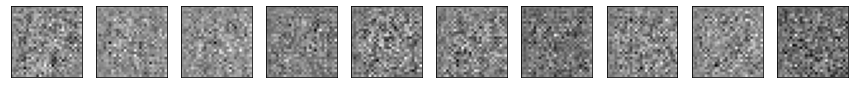

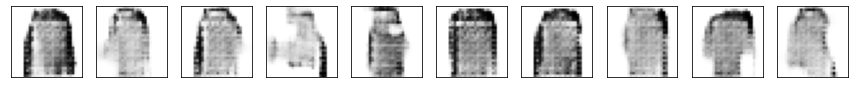

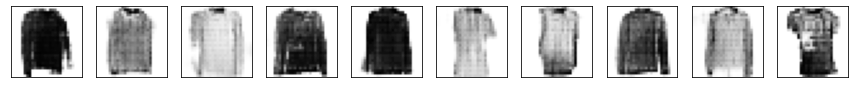

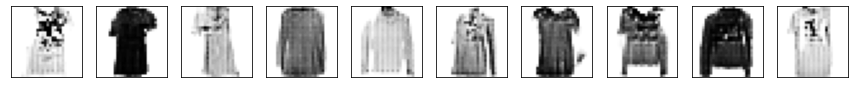

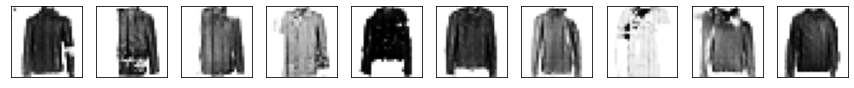

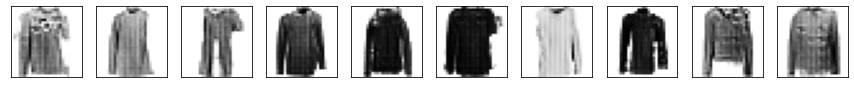

In [38]:
noise_dims = 100
epochs = 5
batch_size = 32
img_shape = (28,28,1)

ones = tf.constant([1.], shape = [batch_size, 1])
zeros = tf.constant([0.], shape = [batch_size, 1])

# 모델 만들기
G = build_generator(noise_dims, img_shape)
D = build_disc(img_shape)

# 컴파일
loss = 'binary_crossentropy'
optimizer = 'adam'
D.compile(loss = loss, optimizer = optimizer)

D.trainable = False
input_noises = layers.Input(shape = noise_dims)
fake_img = G(input_noises)
logit = D(fake_img)
GAN = models.Model(input_noises, logit)
GAN.compile(loss = loss, optimizer = optimizer)
GAN.summary

for epoch in range(epochs+1):
  if epoch != 0:
    for real_imgs in ds: # 20000개중 32개씩
      noises = tf.random.normal(shape = [batch_size, noise_dims]) # p (가우시안 확률분포)
      fake_imgs = G.predict_on_batch(noises)

      # phase 1 : 판별자 훈련
      D.trainable = True 
      # 진짜 이미지 (real_imgs)가 들어오면 1로 대답
      D_loss_real = D.train_on_batch(real_imgs, ones)
      
      # 가짜 이미지 (fake_imgs = G(noises))가 들어오면 0으로 대답
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)

      D_loss = (0.5 * D_loss_real * 0.5 + D_loss_fake) / float(batch_size)

      # phase 2 : 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape = [batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones)

  noises = tf.random.normal(shape = [batch_size, noise_dims])
  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])